In [ ]:
# Install required libraries
!apt-get install lilypond > /dev/null  # For sheet music generation
!pip install librosa numpy matplotlib tensorflow music21 pretty_midi pydub essentia-tensorflow

Saving coniferous-forest-142569.mp3 to coniferous-forest-142569.mp3


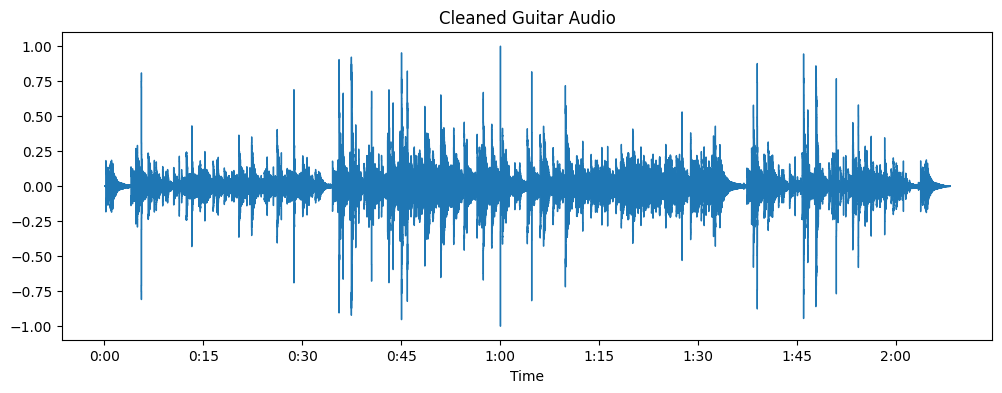

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment

def load_and_clean_audio(file_path, sr=22050):
    # Load audio
    y, sr = librosa.load(file_path, sr=sr)

    # Noise reduction (spectral gating)
    y_clean = librosa.effects.preemphasis(y)

    # Normalize loudness
    y_clean = librosa.util.normalize(y_clean)

    return y_clean, sr

# Test with a sample (upload your guitar recording)
from google.colab import files
uploaded = files.upload()
audio_file = list(uploaded.keys())[0]

# Process audio
cleaned_audio, sr = load_and_clean_audio(audio_file)

# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(cleaned_audio, sr=sr)
plt.title("Cleaned Guitar Audio")
plt.show()

In [ ]:
# First install the original CREPE implementation
!pip install crepe

# Or install directly from GitHub (more reliable)
!pip install git+https://github.com/marl/crepe.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.2 MB/s eta 0:00:00
  Created wheel for crepe: filename=crepe-0.0.16-py3-none-any.whl size=134848677 sha256=db618e47563536f218f9ea6a118f1085c9223619197d4df25b695d03f5bef58c
  Stored in directory: /root/.cache/pip/wheels/fb/54/e2/e2d6bc065d4bbd6920e243682536fe85bb3b33daacbbeb9672
Successfully built crepe
  Cloning https://github.com/marl/crepe.git to /tmp/pip-req-build-ft3xpemo
  Running command git clone --filter=blob:none --quiet https://github.com/marl/crepe.git /tmp/pip-req-build-ft3xpemo
  Resolved https://github.com/marl/crepe.git to commit c9b71ce61491454125a0693f584f7244f29d9884
  Preparing metadata (setup.py) ... done


In [ ]:
import crepe
import numpy as np

def detect_notes(audio, sr, confidence_threshold=0.7):
    try:
        # Run CREPE with proper settings for guitar
        time, frequency, confidence, _ = crepe.predict(
            audio,
            sr,
            model_capacity="full",
            viterbi=True,
            step_size=10,  # Better for guitar
            center=True   # Improves accuracy
        )

        # Filter notes with better thresholding
        notes = []
        for t, f, c in zip(time, frequency, confidence):
            if c >= confidence_threshold and 80 <= f <= 1200:  # Guitar frequency range
                note_name = librosa.hz_to_note(f, octave=False, cents=False)
                notes.append((t, note_name, f, c))

        return notes
    except Exception as e:
        print(f"Error in pitch detection: {str(e)}")
        return []

# Test it
if 'cleaned_audio' in globals() and sr:
    notes = detect_notes(cleaned_audio, sr)
    print(f"Detected {len(notes)} notes")
    if notes:
        print("First 5 notes:", notes[:5])
else:
    print("Please run audio preprocessing first")

401/401 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/step
Detected 6856 notes
First 5 notes: [(np.float64(0.14), 'C♯', np.float64(275.9667904187537), np.float32(0.73785746)), (np.float64(0.15), 'C♯', np.float64(276.5238244951662), np.float32(0.8517459)), (np.float64(0.16), 'C♯', np.float64(275.98079545335014), np.float32(0.9221559)), (np.float64(0.17), 'C♯', np.float64(275.80651395604286), np.float32(0.93565583)), (np.float64(0.18), 'C♯', np.float64(275.6157283189233), np.float32(0.9383132))]


In [ ]:
def detect_rhythm(audio, sr):
    try:
        # Improved onset detection with backtracking
        onset_frames = librosa.onset.onset_detect(
            y=audio,
            sr=sr,
            units='time',
            backtrack=True,
            pre_max=3,
            post_max=3,
            delta=0.2
        )

        # More robust tempo estimation
        tempo, _ = librosa.beat.beat_track(
            y=audio,
            sr=sr,
            start_bpm=80,  # Typical guitar range
            tightness=100
        )

        # Convert tempo from numpy array to float
        tempo_float = float(tempo[0]) if isinstance(tempo, np.ndarray) else float(tempo)

        return onset_frames, tempo_float
    except Exception as e:
        print(f"Error in rhythm detection: {str(e)}")
        return [], 120.0  # Fallback to 120 BPM

# Test it
if 'cleaned_audio' in globals() and sr:
    onsets, bpm = detect_rhythm(cleaned_audio, sr)
    print(f"Detected {len(onsets)} onsets at {bpm:.1f} BPM")
    if len(onsets) > 0:
        print("First 5 onsets (seconds):", onsets[:5])
else:
    print("Please run audio preprocessing first")

Detected 180 onsets at 123.0 BPM
First 5 onsets (seconds): [0.11609977 0.41795918 0.78947846 1.11455782 1.57895692]


In [ ]:
from music21 import stream, note, meter, environment, pitch
import os

def create_sheet_music(notes, onsets, output_file="guitar_transcription"):
    try:
        # Setup LilyPond environment
        environment.set('lilypondPath', '/usr/bin/lilypond')

        # Create a music21 stream
        s = stream.Stream()
        s.insert(0, meter.TimeSignature('4/4'))  # Default time signature

        # Convert Unicode accidentals to music21 format
        def convert_accidental(note_name):
            if '♯' in note_name:
                return note_name.replace('♯', '#')
            elif '♭' in note_name:
                return note_name.replace('♭', 'b')
            return note_name

        # Create notes with proper durations
        for i, (t, note_name, freq, conf) in enumerate(notes):
            try:
                # Skip if confidence is too low
                if conf < 0.6:
                    continue

                # Convert note name format
                fixed_name = convert_accidental(note_name)

                # Create music21 note
                n = note.Note(fixed_name)

                # Calculate duration based on next note's onset
                if i < len(notes)-1:
                    duration = notes[i+1][0] - t
                else:
                    duration = 0.25  # Default quarter note

                # Ensure reasonable duration (32nd note to whole note)
                n.quarterLength = max(0.125, min(1.0, duration))

                # Add string/fret information for guitar
                if freq > 0:
                    midi_num = int(round(librosa.hz_to_midi(freq)))
                    guitar_string = 6 - (midi_num - 40) // 5  # Estimate string
                    n.guitarString = max(1, min(6, guitar_string))

                s.insert(t, n)

            except Exception as note_error:
                print(f"Skipping problematic note {note_name}: {str(note_error)}")
                continue

        # Generate PDF output
        print("Generating sheet music...")
        s.write('lilypond', f'{output_file}.ly')
        !lilypond {output_file}.ly 2> /dev/null

        # Verify output
        if os.path.exists(f'{output_file}.pdf'):
            print(f"✅ Success! Download your sheet music:")
            files.download(f'{output_file}.pdf')
            return True
        else:
            print("❌ PDF generation failed - check LilyPond installation")
            return False

    except Exception as e:
        print(f"Fatal error in sheet music generation: {str(e)}")
        return False

# Run the function with your detected notes
if 'notes' in globals() and len(notes) > 0:
    success = create_sheet_music(notes[:100], onsets)  # Process first 100 notes for testing
else:
    print("No notes detected - please run previous steps first")

Generating sheet music...
✅ Success! Download your sheet music:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>